# Predicting flight delays

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()

## Load and inspect the dataset



In [3]:
df = pd.read_csv('flight-data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   carrier       10000 non-null  object 
 1   flight        10000 non-null  int64  
 2   tailnum       9926 non-null   object 
 3   origin        10000 non-null  object 
 4   dest          10000 non-null  object 
 5   air_time      9716 non-null   float64
 6   distance      10000 non-null  int64  
 7   hour          10000 non-null  int64  
 8   minute        10000 non-null  int64  
 9   temp          9952 non-null   float64
 10  dewp          9952 non-null   float64
 11  humid         9952 non-null   float64
 12  wind_dir      9731 non-null   float64
 13  wind_speed    9951 non-null   float64
 14  wind_gust     2387 non-null   float64
 15  precip        9954 non-null   float64
 16  pressure      8808 non-null   float64
 17  visib         9954 non-null   float64
 18  type          8499 non-null

### *** Some of the labels are na so we will have to drop those rows

In [4]:
df = df[df['arr_delay'].notna()]

In [5]:
df.dtypes

carrier          object
flight            int64
tailnum          object
origin           object
dest             object
air_time        float64
distance          int64
hour              int64
minute            int64
temp            float64
dewp            float64
humid           float64
wind_dir        float64
wind_speed      float64
wind_gust       float64
precip          float64
pressure        float64
visib           float64
type             object
manufacturer     object
model            object
engines         float64
seats           float64
engine           object
arr_delay       float64
dtype: object

From inspection we can identify a couple of unessesary features: flight number, and tailnum which are unique to the flight/ aircraft. The types all seem to be properly encoded. We will also want to encode the object data types as categorical. Finally there are some missing values which we can impute. I will impute median for the numerical values and mode for the categorical.

## Drop unnecessary features

In [6]:
df = df.drop(['tailnum', 'flight'], axis=1)

AxesSubplot(0.125,0.125;0.775x0.755)


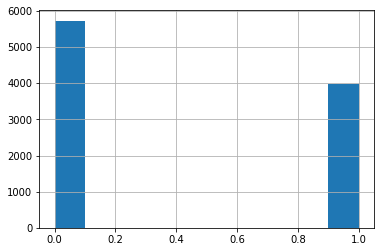

In [7]:
print(df['arr_delay'].hist())

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop('arr_delay', axis=1)
y = df['arr_delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Create Pipeline

In [9]:
# From: https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

objects = (X.dtypes == 'object')
numerics = (X.dtypes != 'object')

numeric_features = list(numerics[numerics].index)
categorical_features = list(objects[objects].index)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

## Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {'classifier__C': (0.1, 1, 10, 100)}


lg = Pipeline(steps=[('preprocessor', preprocessor), 
                     ('classifier', LogisticRegression(max_iter=1000))])
gs_lg = GridSearchCV(lg, params)

gs_lg.fit(X_train, y_train)
gs_lg.score(X_test, y_test)

0.7011115685467271

## Decision Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier

params = {'classifier__max_depth': (1, 10, 100),
          'classifier__max_features': ('auto', 'sqrt', 'log2')}


dtc = Pipeline(steps=[('preprocessor', preprocessor), 
                      ('classifier', DecisionTreeClassifier())])
gs_dtc = GridSearchCV(dtc, params)

gs_dtc.fit(X_train, y_train)
gs_dtc.score(X_test, y_test)

0.5780156442980651

## SVM

In [12]:
from sklearn import svm

params = {'classifier__C': (0.1, 1),
          'classifier__kernel': ('linear', 'rbf')}

s = Pipeline(steps=[('preprocessor', preprocessor), 
                      ('classifier', svm.SVC())])
gs_s = GridSearchCV(s, params)

gs_s.fit(X_train, y_train)
gs_s.score(X_test, y_test)

0.7015232606010704

As we can see logistics regression and svm performed better than decision trees, and while there is not much difference between svm and logistic regression I would still choose logistic regression in production due to the faster run time.

In [13]:
from sklearn.ensemble import VotingClassifier

lg = LogisticRegression(max_iter=1000)
dtc = DecisionTreeClassifier()
s = svm.SVC()

vc = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', VotingClassifier(estimators=[('dtc', dtc), ('lg', lg), ('s', s)]))])

vc.fit_transform(X_train, y_train)
vc.score(X_test, y_test)

0.69287772745986

As we can see this did not result in a better result than any of the other classifiers on their own.

In [14]:
from sklearn.ensemble import AdaBoostClassifier

ada = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', AdaBoostClassifier(n_estimators=100, random_state=0))])

ada.fit(X_train, y_train)
ada.score(X_test, y_test)

0.6788801976121861

Logistic regression still seems to be the best choice.